<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4 Final Model

This notebook containts the evaluation of our final model and recommendations, using our entire dataset created from our simulation.

In [1]:
# You will need to run the folding command from your terminal to run this notebook
# or uncomment the line below:
# conda install -c conda-forge imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, \
accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay)

from sklearn.metrics import make_scorer, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('data/preprocessed_data.csv')
df.head()

,Unnamed: 0,lat,long,amt,is_fraud,merch_lat,merch_long,timedelta,time,weekday,...,category_misc_net_fraction_rolling_100,category_misc_pos_fraction_rolling_100,category_personal_care_fraction_rolling_100,category_shopping_net_fraction_rolling_100,category_shopping_pos_fraction_rolling_100,category_travel_fraction_rolling_100,thirty_day_avg_amt,total_daily_amount,total_daily_transactions,probability_density
0,691900,0.621990,-1.441024,18.24,0,0.621654,-1.428358,0,12960,1,...,0.0,0.0,0.0,0.0,0.0,0.0,18.24,18.24,1,1.0
1,754418,0.770415,-1.801271,7.42,0,0.780922,-1.795226,0,23040,1,...,0.0,0.0,0.0,0.0,0.0,0.0,7.42,7.42,1,1.0
2,2446544,0.607542,-1.570962,82.07,0,0.602956,-1.553939,0,73440,5,...,0.0,0.0,0.0,0.0,0.0,0.0,82.07,82.07,1,1.0
3,1388156,0.800787,-1.664730,43.03,0,0.791665,-1.659873,0,10080,0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.03,43.03,1,1.0
4,1475370,0.534614,-1.538661,80.40,0,0.519655,-1.521959,0,10080,0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.40,80.40,1,1.0


In [9]:
# drop the probability density feature for now
df.drop(['probability_density', 'Unnamed: 0'], axis=1, inplace=True)

In [10]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

In [11]:
y.value_counts()

0    2586148
1      14306
Name: is_fraud, dtype: int64

In [12]:
y.value_counts(normalize=True).mul(100).round(2)

0    99.45
1     0.55
Name: is_fraud, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1,
                                                    random_state = 42, 
                                                    stratify = y)

In [14]:
print(y_train.value_counts(normalize=True).mul(100).round(2))
print(y_train.value_counts())

0    99.45
1     0.55
Name: is_fraud, dtype: float64
0    2327533
1      12875
Name: is_fraud, dtype: int64


In [15]:
# Scale our data...
ss = StandardScaler()

# Scaler fits or trains on the X_train only - does not see the
# X_test (or imagined new data). 
X_train_sc = ss.fit_transform(X_train)

# We take the scaling from X_train and apply that to the X_test 
X_test_sc = ss.transform(X_test)

In [16]:
# leverage function from GA lesson on smote
def metrics(y_test, y_predict):
    print(f"Accuracy score: {accuracy_score(y_test, y_predict)} \n")
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['not_fraud', 'Actually_fraud'], 
                            columns=['Predicted_not_Fraud', 'Predicted_fraud']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')

In [17]:
# Now we can create synthetic data for our training set
sm = SMOTE(random_state=42, n_jobs=-1)

X_train_smote, y_train_smote = sm.fit_resample(X_train_sc, y_train)

In [18]:
X_train_smote.shape, y_train_smote.shape

((4655066, 89), (4655066,))

In [19]:
y_train_smote.value_counts()

0    2327533
1    2327533
Name: is_fraud, dtype: int64

## Random Forest model

In [20]:
def weighted_recall_scorer(y_true, y_pred, beta=10, **kwargs):
    
    """
    Custom scoring function to prioritize recall for the minority class.
    
    Parameters: y_true(true target values), y_pred(predicted target values),
                beta(weight of recall score)
    
    Returns: The fbeta-score of the positive class.
    """
    # we only need the fbeta_score from the precision_recall_fscore_support function
    # therefor we assign "_, _," to denote we only need to return the fbeta_score
    _, _, fbeta_score, _ = precision_recall_fscore_support(y_true, y_pred, 
                                                           beta=beta, pos_label=1)
    return fbeta_score[1]

custom_scorer = make_scorer(weighted_recall_scorer)

In [21]:
pipe_rf_cs = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('rfc', RandomForestClassifier())
    ])

pipe_params_rf_cs = {
     'sampling__sampling_strategy': ['minority'],
     'sampling__k_neighbors': [15],
     'rfc__max_depth': [20],
}

# pipe_params_rf_cs = {
#      'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#      'sampling__k_neighbors': [9, 12, 15],
#      'rfc__max_depth': [20, 50, 100],
# }

# Best params: 
# {'rfc__max_depth': 20,
#  'sampling__k_neighbors': 15,
#  'sampling__sampling_strategy': 'minority'}

In [22]:
grid_rf_cs = GridSearchCV(pipe_rf_cs, pipe_params_rf_cs, n_jobs=-1, scoring=custom_scorer)
grid_rf_cs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [20], 'sampling__k_neighbors': [15],
                         'sampling__sampling_strategy': ['minority']},
             scoring=make_scorer(weighted_recall_scorer))

In [23]:
grid_rf_cs.score(X_train, y_train), grid_rf_cs.score(X_test, y_test)

(0.9952678307828569, 0.9721544195437668)

In [24]:
grid_rf_cs.best_params_

{'rfc__max_depth': 20,
 'sampling__k_neighbors': 15,
 'sampling__sampling_strategy': 'minority'}

In [25]:
grid_preds_rf_cs = grid_rf_cs.predict(X_test)

In [26]:
metrics(y_test, grid_preds_rf_cs)

Accuracy score: 0.9993616514001369 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                    258488              127
Actually_fraud                   39             1392 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    258615
           1       0.92      0.97      0.94      1431

    accuracy                           1.00    260046
   macro avg       0.96      0.99      0.97    260046
weighted avg       1.00      1.00      1.00    260046

-----------------------------------------------------------------


## Final model evaluation

Text(0.5, 1.0, 'Test')

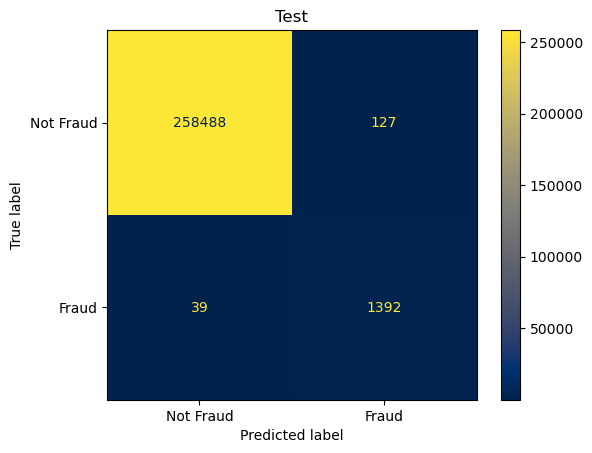

In [33]:
ConfusionMatrixDisplay.from_estimator(grid_rf_cs, X_test, y_test, cmap='cividis', display_labels=['Not Fraud', 'Fraud'], colorbar=True)
plt.title('Test')

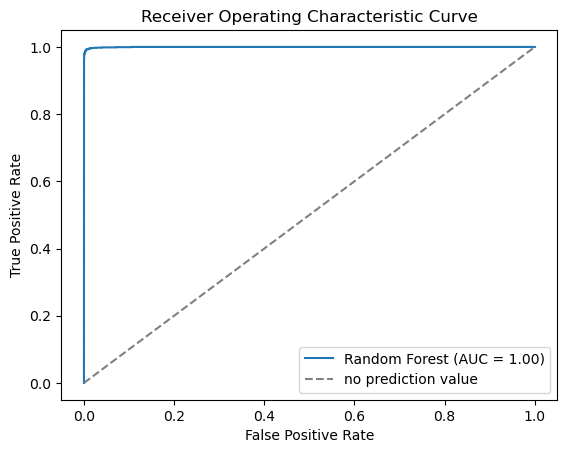

In [28]:
# Create an ax object
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(grid_rf_cs, X_test, y_test, 
                               ax=ax, name='Random Forest')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Necessary to label the baseline
plt.legend();

Our model improved in crucial performance metrics when tested on a large data set. Our recall score is up to 0.97, and we observe approximately 2% of false negatives in the testing set. In addition, our ROC curve indicates our model performs very well regarding its ability to distinguish between classes. With more time, we would run a full grid search and test multiple algorithms on the entire data set. Nonetheless, our model performs very well as currently implemented on the simulation-generated data. 

# Summary and Recommendations

In this project, we leveraged a simulation-generated data to train and build a fraud detection model to protect consumers from credit card fraud. We analyzed the data and highlighted meaningful trends that related to predicting fraudulent activity. We engineered features to account for different consumer spending habits and calculation window sizes to reflect short and long term changes in spending habits, wWe built several classification models to evaluate model performance and address the challenges of highly imbalanced classes. We engineered several features and transformed the data when applicable to aid in model performance. The final model was a Random Forest algorithm which was nearly 99% accurate, with only 2% false negative predictions. We recommend implementing our algorithm to reduce future fraud and protect consumers. 